In [133]:
order = ['snow','water','settlement','forest','vl','low','mod','vh','high']


In [134]:
import rasterio 
import pandas as pd 
import geopandas as gpd
from rasterio.features import shapes
from shapely.geometry import shape


ag_csv_data = pd.read_csv('../data/csv/agri.csv')


ag_csv_data_geo = gpd.GeoDataFrame(
    ag_csv_data, 
    geometry=gpd.points_from_xy(ag_csv_data.long, ag_csv_data.lat),
    crs='EPSG:4326'
)


In [135]:
ag_csv_data_geo.to_file('../results/agri_points.geojson', driver='GeoJSON')

In [136]:
ag_csv_data_geo

,long,lat,boron,nitrogen,phos,potas,pH,zinc,clay,OM,...,Silt,Rainfall,Temp,Elevation,Slope,nearest_rainfall,Water,Road,LULC_Code,geometry
0,83.85515,28.60636,0.657479,0.275707,160.591110,422.590637,6.513292,3.518640,14.486905,4.425440,...,36.245235,1981.199951,-11.756000,7177,51.043102,161.810959,1226.073853,8431.494141,3,POINT (83.85515 28.60636)
1,83.86235,28.60636,0.659152,0.276924,160.055542,425.039581,6.507481,3.472359,14.470653,4.427260,...,36.186974,1969.310059,-12.372400,6921,57.620865,203.358749,1020.155090,8312.815430,3,POINT (83.86235 28.60636)
2,83.86954,28.60636,0.660816,0.278224,159.514252,427.556702,6.501764,3.426556,14.456827,4.429185,...,36.127678,1955.609985,-9.350880,6606,37.788227,151.909271,1140.568115,8286.573242,2,POINT (83.86954 28.60636)
3,83.87673,28.60636,0.662464,0.279596,158.962692,430.118469,6.496194,3.382173,14.444460,4.431137,...,36.067360,1938.390015,-11.219000,6505,31.579657,209.890427,1700.258545,8289.179688,3,POINT (83.87673 28.60636)
4,83.88393,28.60636,0.664091,0.281037,158.400024,432.720184,6.490781,3.339361,14.433300,4.433113,...,36.006138,1917.750000,-18.900101,6950,31.192774,226.123306,2281.136231,8352.131836,2,POINT (83.88393 28.60636)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3699,84.04937,28.08845,0.704252,0.156124,70.170723,208.800934,6.032872,1.829535,13.977061,2.858784,...,50.064411,1988.359985,12.733700,3263,26.053015,235.491470,2890.439453,2506.391846,10,POINT (84.04937 28.08845)
3700,84.05656,28.08845,0.698491,0.155032,69.327072,193.635513,5.989256,1.850665,13.635312,2.874999,...,50.704990,1990.930054,9.532490,3662,12.283256,242.447189,2210.335938,2107.059570,7,POINT (84.05656 28.08845)
3701,84.06375,28.08845,0.700715,0.143281,64.773491,180.032379,5.980727,1.803925,12.781516,2.792610,...,51.445965,1990.930054,8.137450,3497,18.563007,1.432096,1360.206787,1855.397583,10,POINT (84.06375 28.08845)
3702,84.07095,28.08845,0.718005,0.133161,63.206043,216.115891,5.836149,1.819670,13.793143,2.583888,...,48.177200,1990.930054,11.338500,3361,7.300463,31.607502,680.103394,1800.250000,4,POINT (84.07095 28.08845)


Raster to vector 

In [137]:
all_polygons = []
for layer_name in order:
    tiff_path = f'../data/tiff/{layer_name}.tif'
    try:
        with rasterio.open(tiff_path) as src:
            image = src.read(1)
            nodata = src.nodata
            
            mask = (image > 0) & (image != nodata) if nodata is not None else image > 0
            
            results = shapes(image, mask=mask, transform=src.transform)
            
            geoms = []
            for geom, value in results:
                if value > 0 and (nodata is None or value != nodata):
                    geoms.append(shape(geom))
            
            if geoms:
                gdf = gpd.GeoDataFrame({'class': [layer_name] * len(geoms)}, geometry=geoms, crs=src.crs)
                all_polygons.append(gdf)
                print(f"Vectorized {layer_name}: {len(geoms)} polygons")
    except Exception as e:
        print(f"Error processing {layer_name}: {e}")

Vectorized snow: 1618 polygons
Vectorized water: 293 polygons
Vectorized settlement: 1048 polygons
Vectorized forest: 8243 polygons
Vectorized vl: 4979 polygons
Vectorized low: 9858 polygons
Vectorized mod: 509 polygons
Vectorized vh: 318 polygons
Vectorized high: 6039 polygons


In [138]:
layers_gdf = pd.concat(all_polygons, ignore_index=True)

In [139]:
layers_gdf.to_file('../results/all_layers.geojson', driver='GeoJSON')

Vector to priority layers 

In [140]:
priority_layers = []

for i, layer_name in enumerate(order):
    current_layer = layers_gdf[layers_gdf['class'] == layer_name].copy()
    
    if len(current_layer) > 0:
        current_geom = current_layer.union_all()
        
        for higher_priority in order[:i]:
            higher_layer = layers_gdf[layers_gdf['class'] == higher_priority]
            if len(higher_layer) > 0:
                higher_geom = higher_layer.union_all()
                current_geom = current_geom.difference(higher_geom)
        
        if not current_geom.is_empty:
            priority_layers.append(gpd.GeoDataFrame(
                {'class': [layer_name]}, 
                geometry=[current_geom], 
                crs=layers_gdf.crs
            ))
            print(f"Processed {layer_name}")

layers_gdf = pd.concat(priority_layers, ignore_index=True)
print(f"\nFinal layers: {len(layers_gdf)}")

Processed snow
Processed water
Processed settlement
Processed forest
Processed vl
Processed low
Processed mod
Processed vh
Processed high

Final layers: 9


In [141]:
layers_gdf.to_file('../results/priority_layers.geojson', driver='GeoJSON')

In [142]:
layers_gdf

,class,geometry
0,snow,"MULTIPOLYGON (((83.75791 28.47086, 83.75656 28..."
1,water,"MULTIPOLYGON (((83.91529 28.22804, 83.91529 28..."
2,settlement,"MULTIPOLYGON (((83.86867 28.24071, 83.8684 28...."
3,forest,"MULTIPOLYGON (((83.76087 28.31644, 83.76114 28..."
4,vl,"MULTIPOLYGON (((83.7668 28.42208, 83.7668 28.4..."
5,low,"MULTIPOLYGON (((83.73904 28.33773, 83.73931 28..."
6,mod,"MULTIPOLYGON (((83.76114 28.31617, 83.76114 28..."
7,vh,"MULTIPOLYGON (((83.88484 28.23586, 83.88484 28..."
8,high,"MULTIPOLYGON (((83.76168 28.29299, 83.76168 28..."


In [143]:
layers_gdf_exploded= layers_gdf.explode()

In [144]:
layers_gdf_exploded

,class,geometry
0,snow,"POLYGON ((83.75791 28.47086, 83.75656 28.47086..."
0,snow,"POLYGON ((83.76141 28.4722, 83.76141 28.4714, ..."
0,snow,"POLYGON ((83.77731 28.47193, 83.77731 28.4722,..."
0,snow,"POLYGON ((83.77596 28.47247, 83.77731 28.47247..."
0,snow,"POLYGON ((83.75575 28.47301, 83.75575 28.47274..."
...,...,...
8,high,"POLYGON ((84.20554 28.44822, 84.20554 28.44795..."
8,high,"POLYGON ((84.19664 28.45064, 84.19718 28.45064..."
8,high,"POLYGON ((84.20985 28.45415, 84.21039 28.45415..."
8,high,"POLYGON ((84.21227 28.45442, 84.21227 28.45415..."


In [145]:
ag_csv_data_geo = ag_csv_data_geo.sjoin(layers_gdf_exploded, how='left', predicate='within')
ag_csv_data_geo = ag_csv_data_geo.drop(columns=['index_right'], errors='ignore')

In [146]:
ag_csv_data_geo

,long,lat,boron,nitrogen,phos,potas,pH,zinc,clay,OM,...,Rainfall,Temp,Elevation,Slope,nearest_rainfall,Water,Road,LULC_Code,geometry,class
0,83.85515,28.60636,0.657479,0.275707,160.591110,422.590637,6.513292,3.518640,14.486905,4.425440,...,1981.199951,-11.756000,7177,51.043102,161.810959,1226.073853,8431.494141,3,POINT (83.85515 28.60636),snow
1,83.86235,28.60636,0.659152,0.276924,160.055542,425.039581,6.507481,3.472359,14.470653,4.427260,...,1969.310059,-12.372400,6921,57.620865,203.358749,1020.155090,8312.815430,3,POINT (83.86235 28.60636),snow
2,83.86954,28.60636,0.660816,0.278224,159.514252,427.556702,6.501764,3.426556,14.456827,4.429185,...,1955.609985,-9.350880,6606,37.788227,151.909271,1140.568115,8286.573242,2,POINT (83.86954 28.60636),snow
3,83.87673,28.60636,0.662464,0.279596,158.962692,430.118469,6.496194,3.382173,14.444460,4.431137,...,1938.390015,-11.219000,6505,31.579657,209.890427,1700.258545,8289.179688,3,POINT (83.87673 28.60636),snow
4,83.88393,28.60636,0.664091,0.281037,158.400024,432.720184,6.490781,3.339361,14.433300,4.433113,...,1917.750000,-18.900101,6950,31.192774,226.123306,2281.136231,8352.131836,2,POINT (83.88393 28.60636),snow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3699,84.04937,28.08845,0.704252,0.156124,70.170723,208.800934,6.032872,1.829535,13.977061,2.858784,...,1988.359985,12.733700,3263,26.053015,235.491470,2890.439453,2506.391846,10,POINT (84.04937 28.08845),vh
3700,84.05656,28.08845,0.698491,0.155032,69.327072,193.635513,5.989256,1.850665,13.635312,2.874999,...,1990.930054,9.532490,3662,12.283256,242.447189,2210.335938,2107.059570,7,POINT (84.05656 28.08845),forest
3701,84.06375,28.08845,0.700715,0.143281,64.773491,180.032379,5.980727,1.803925,12.781516,2.792610,...,1990.930054,8.137450,3497,18.563007,1.432096,1360.206787,1855.397583,10,POINT (84.06375 28.08845),forest
3702,84.07095,28.08845,0.718005,0.133161,63.206043,216.115891,5.836149,1.819670,13.793143,2.583888,...,1990.930054,11.338500,3361,7.300463,31.607502,680.103394,1800.250000,4,POINT (84.07095 28.08845),vh


In [147]:
ag_csv_data_geo['class'].value_counts()

class
forest        1611
snow           467
vl             439
high           340
low            281
vh             165
mod            105
settlement      28
water           21
Name: count, dtype: int64

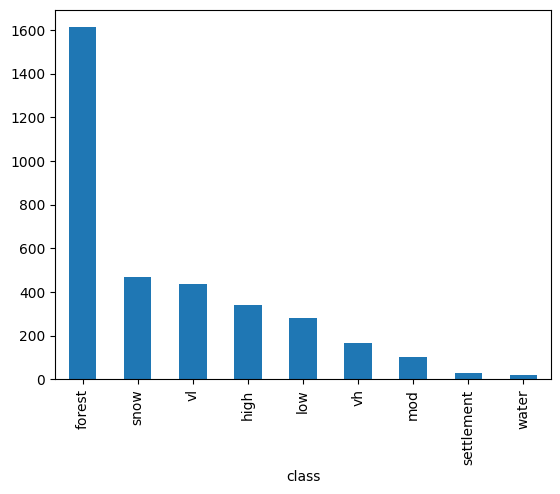

In [148]:
import matplotlib.pyplot as plt

ag_csv_data_geo['class'].value_counts().plot(kind='bar')
plt.show()

In [149]:
mappings = {
    'snow': 'not_suitable',
    'water': 'not_suitable',
    'settlement': 'not_suitable',
    'forest': 'not_suitable',
    'vl': 'low_suitability',
    'low': 'low_suitability',
    'mod': 'moderate_suitability',
    'vh': 'high_suitability',
    'high': 'high_suitability'   
}
 
target_classes = ['not_suitable','low_suitability','moderate_suitability','high_suitability']
ag_csv_data_geo['class_level_1'] = ag_csv_data_geo['class'].map(mappings)

In [151]:
ag_csv_data_geo['class_level_1'].value_counts()

class_level_1
not_suitable            2127
low_suitability          720
high_suitability         505
moderate_suitability     105
Name: count, dtype: int64

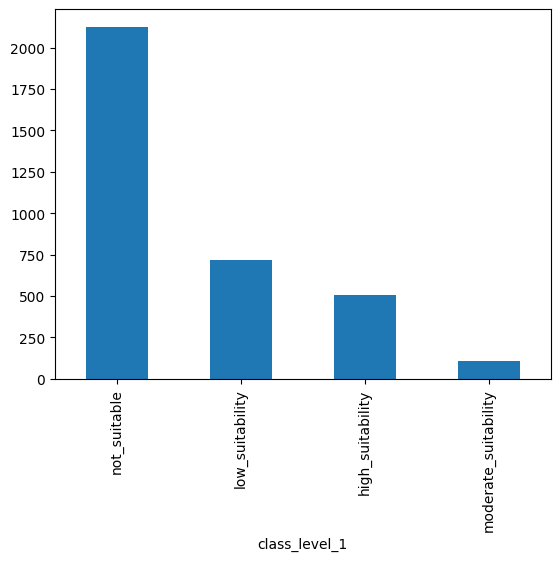

In [ ]:
ag_csv_data_geo['class_level_1'].value_counts().plot(kind='bar')
plt.show()

In [152]:
mappings = {
    'snow': 'not_suitable',
    'water': 'not_suitable',
    'settlement': 'not_suitable',
    'forest': 'not_suitable',
    'vl': 'very_low_suitability',
    'low': 'low_suitability',
    'mod': 'moderate_suitability',
    'vh': 'very_high_suitability',
    'high': 'high_suitability'   
}
 
target_classes = ['not_suitable','very_low_suitability','low_suitability','moderate_suitability','high_suitability','very_high_suitability']
ag_csv_data_geo['class_level_2'] = ag_csv_data_geo['class'].map(mappings)

In [153]:
ag_csv_data_geo['class_level_2'].value_counts()

class_level_2
not_suitable             2127
very_low_suitability      439
high_suitability          340
low_suitability           281
very_high_suitability     165
moderate_suitability      105
Name: count, dtype: int64

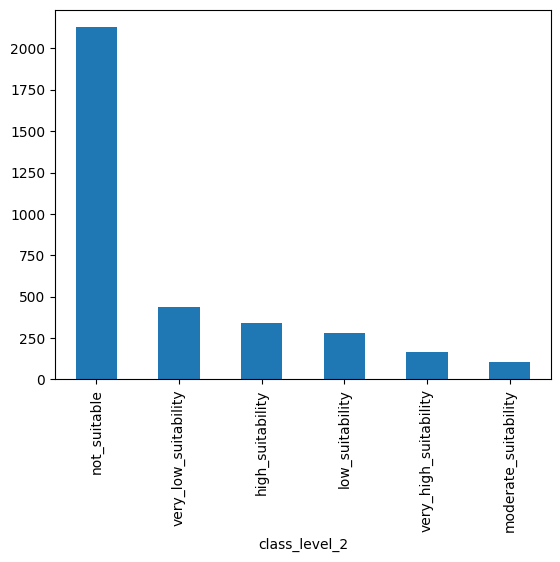

In [154]:
ag_csv_data_geo['class_level_2'].value_counts().plot(kind='bar')
plt.show()

In [155]:
ag_csv_data_geo.to_file('../results/agri_points_with_labels.geojson', driver='GeoJSON')